In [ ]:
#hide
!nvidia-smi

In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git
    #import os; os.kill(os.getpid(), 9)

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

# Full Reformer model experiment

> Fit deep models using very long sequences

In [ ]:
#hide
from fastai.text.all import *
from reformer_fastai.all import *

In [ ]:
#Run setup
n_epochs = 4
bs = 1
sl = 2**14
n_layers = 3
seed = 2

## Experiment Tracking

Make sure you have wandb and are logged in:

In [ ]:
# hide
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

In [ ]:
import wandb

WANDB_NAME = f'n_layers-{n_layers}_enwik8_sl-{sl}_bs-{bs}_n_eps-{n_epochs}_seed-{seed}'
GROUP = 'TEST'
NOTES = 'ReformerLM on enwik8 sl=32k'
CONFIG = {}
TAGS = ['lm','reformer','enwik8', 'test']

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [ ]:
path = untar_data('http://mattmahoney.net/dc/enwik8.zip', dest='/data')

## Prepare Data

In [ ]:
df = pd.DataFrame({'text':read_lines(path)})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [ ]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [ ]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 2min 13s, sys: 2.77 s, total: 2min 15s
Wall time: 2min 12s


In [ ]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
%%time
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 16.5 s, sys: 1.64 s, total: 18.2 s
Wall time: 21 s


In [ ]:
#collapse_output
dls.show_batch()

,text,text_
0,":Whether in '''sea or fire, in earth or air''',\n*[http://www.geraldgardner.com/ GeraldGardner.com] an online reference resource\n <timestamp>2006-02-20T01:57:35Z</timestamp>\n[[es:Delta]]\n** [[Battle of Long Tan]]\n*[http://www.spinoza.net The Spinoza Net]\n <minor />\n[[is:Ermarsundseyjar]]\n <contributor>\nIt is generally agreed that the '''Finno-Ugric''' subfamily of the [[Uralic languages]] has the following members:\nIn 1687, [[Isaac Newton]] published the ''[[Philosophiae Naturalis Principia Mathematica|Principia Mathematica]],'' detailing two comprehensive and successful physical theories: [[Newton's laws of motion]], which lead to classical mechanics; and [[gravity|Newton's Law of Gravitation]], which describes the fundamental force of gravity. The behavior of electricity and magnetism was studied by [[Michael Faraday|Faraday]], [[Georg Ohm|Ohm]], and others during the early 19th century. These studies led to the unification of the two phenomena into a single theory of [[electromagnetism]], by [[James Clerk Maxwell|Maxwell]] (known as [[Maxwells equations|Maxwell's equations]]).\n <comment>bypassed disambiguation MA</comment>\n[[es:BIND]]\n|Abelian group\n[[Image:Insulincrystals.jpg|left|300px|frame|Insulin [[crystal|crystals]]]]\n","Whether in '''sea or fire, in earth or air''',\n*[http://www.geraldgardner.com/ GeraldGardner.com] an online reference resource\n <timestamp>2006-02-20T01:57:35Z</timestamp>\n[[es:Delta]]\n** [[Battle of Long Tan]]\n*[http://www.spinoza.net The Spinoza Net]\n <minor />\n[[is:Ermarsundseyjar]]\n <contributor>\nIt is generally agreed that the '''Finno-Ugric''' subfamily of the [[Uralic languages]] has the following members:\nIn 1687, [[Isaac Newton]] published the ''[[Philosophiae Naturalis Principia Mathematica|Principia Mathematica]],'' detailing two comprehensive and successful physical theories: [[Newton's laws of motion]], which lead to classical mechanics; and [[gravity|Newton's Law of Gravitation]], which describes the fundamental force of gravity. The behavior of electricity and magnetism was studied by [[Michael Faraday|Faraday]], [[Georg Ohm|Ohm]], and others during the early 19th century. These studies led to the unification of the two phenomena into a single theory of [[electromagnetism]], by [[James Clerk Maxwell|Maxwell]] (known as [[Maxwells equations|Maxwell's equations]]).\n <comment>bypassed disambiguation MA</comment>\n[[es:BIND]]\n|Abelian group\n[[Image:Insulincrystals.jpg|left|300px|frame|Insulin [[crystal|crystals]]]]\n"


In [ ]:
vocab_sz = btt.vocab_size

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((1, 16384), (1, 16384))

In [ ]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

In [ ]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
pad_id = btt.pad_token_id
config = NLayersConfig(n_layers=n_layers, max_seq_len=sl, pad_idx=pad_id, seed=seed)
config

ReformerLM config 
--------------------
vocab_sz        256
d_model         1024
n_layers        3
n_heads         8
d_ff            4096
ff_chunks       64
attn_dropout    0.1
ff_dropout      0.1
emb_dropout     0.1
tie_weights     True
causal          True
pos_enc         axial
max_seq_len     16384
axial_shape     None
axial_emb_dims  None
pad_idx         0
prenorm         False
attn_bias       False
bucket_size     64
use_lsh         True
n_hashes        8
rev_thres       0
seed            2

In [ ]:
learn = Learner(dls, ReformerLM.from_config(config),
                loss_func=CrossEntropyLossFlat(), opt_func=adafactor,
                cbs = [GradientAccumulation(n_acc=8), GradientClip(1.0),
                       PadBatchCallback(bucket_size=config.bucket_size,
                                        val=pad_id, y_val=pad_id)],
                metrics=[accuracy, perplexity, bpc])

In [ ]:
#hide
# learn.lr_find()

In [ ]:
learn.fit(n_epochs, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,2.679134,2.664143,0.250359,14.355639,3.843546,2:43:46
1,1.861361,1.778351,0.501252,5.920086,2.565618,2:43:47
2,1.823950,1.780039,0.515367,5.930086,2.568053,2:43:00
3,1.830684,1.738252,0.524591,5.687393,2.507768,2:43:45


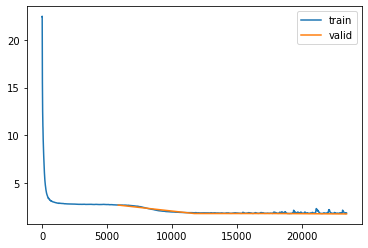

In [ ]:
learn.recorder.plot_loss()